In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")



In [ ]:
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

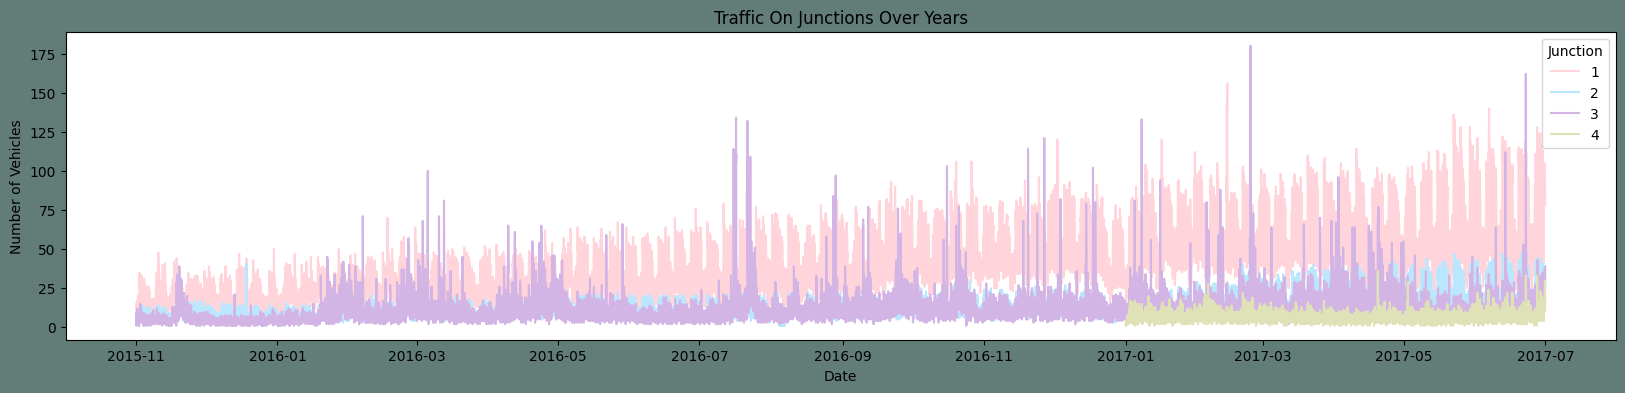

In [ ]:
df=data.copy()
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")


In [ ]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()


,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


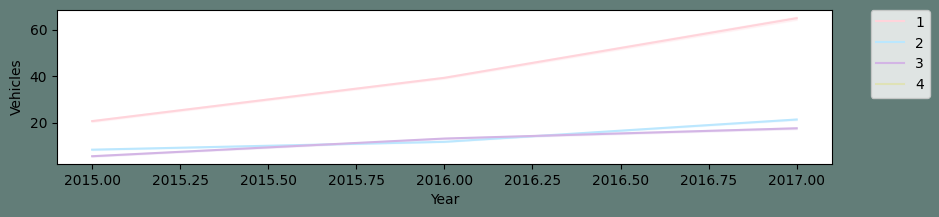

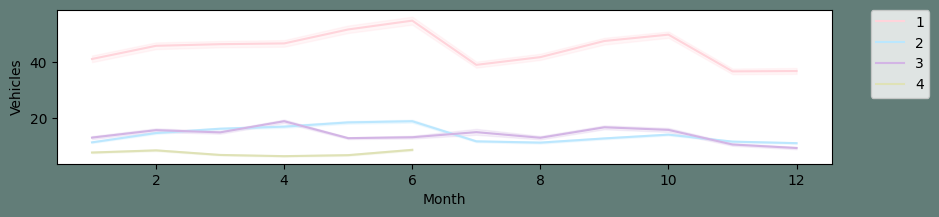

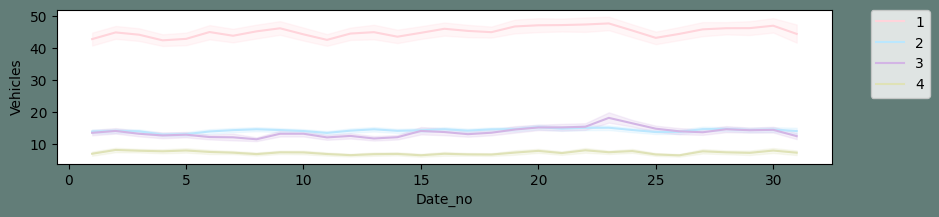

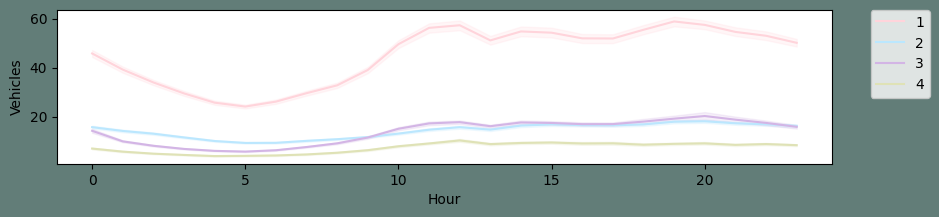

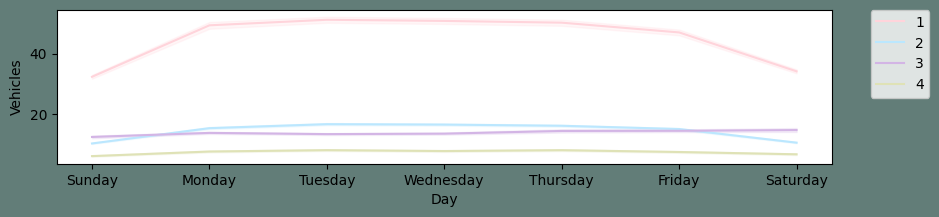

In [ ]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

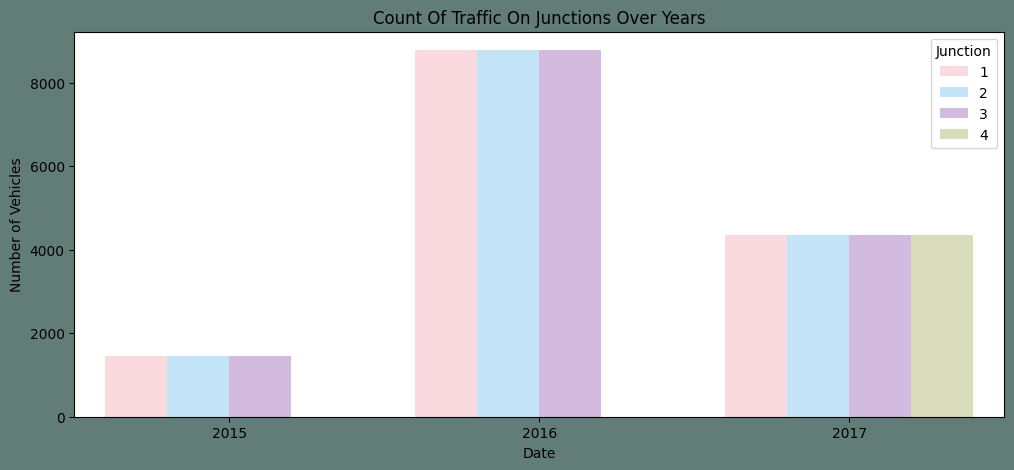

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<Axes: >

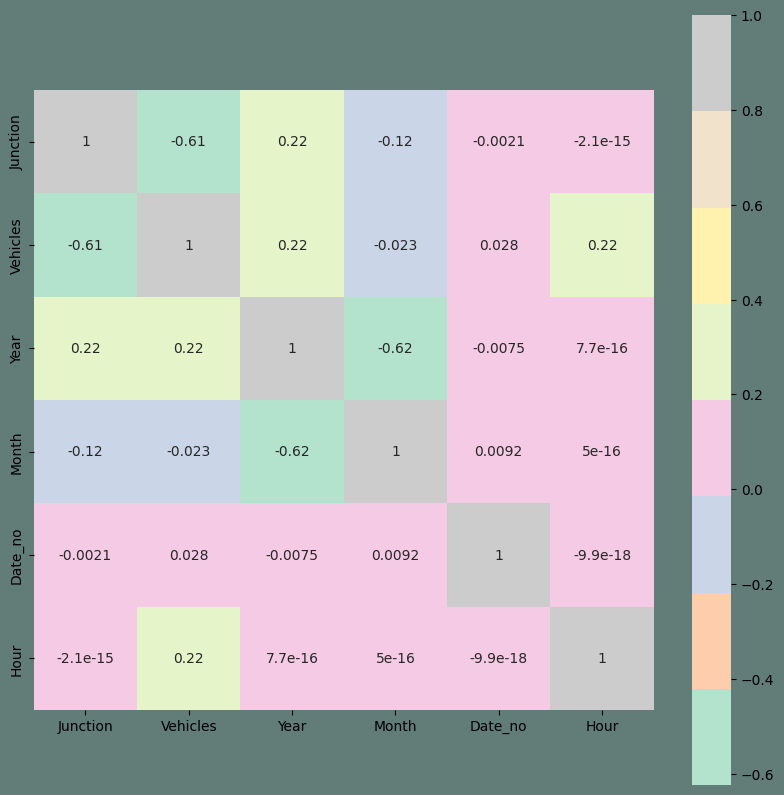

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

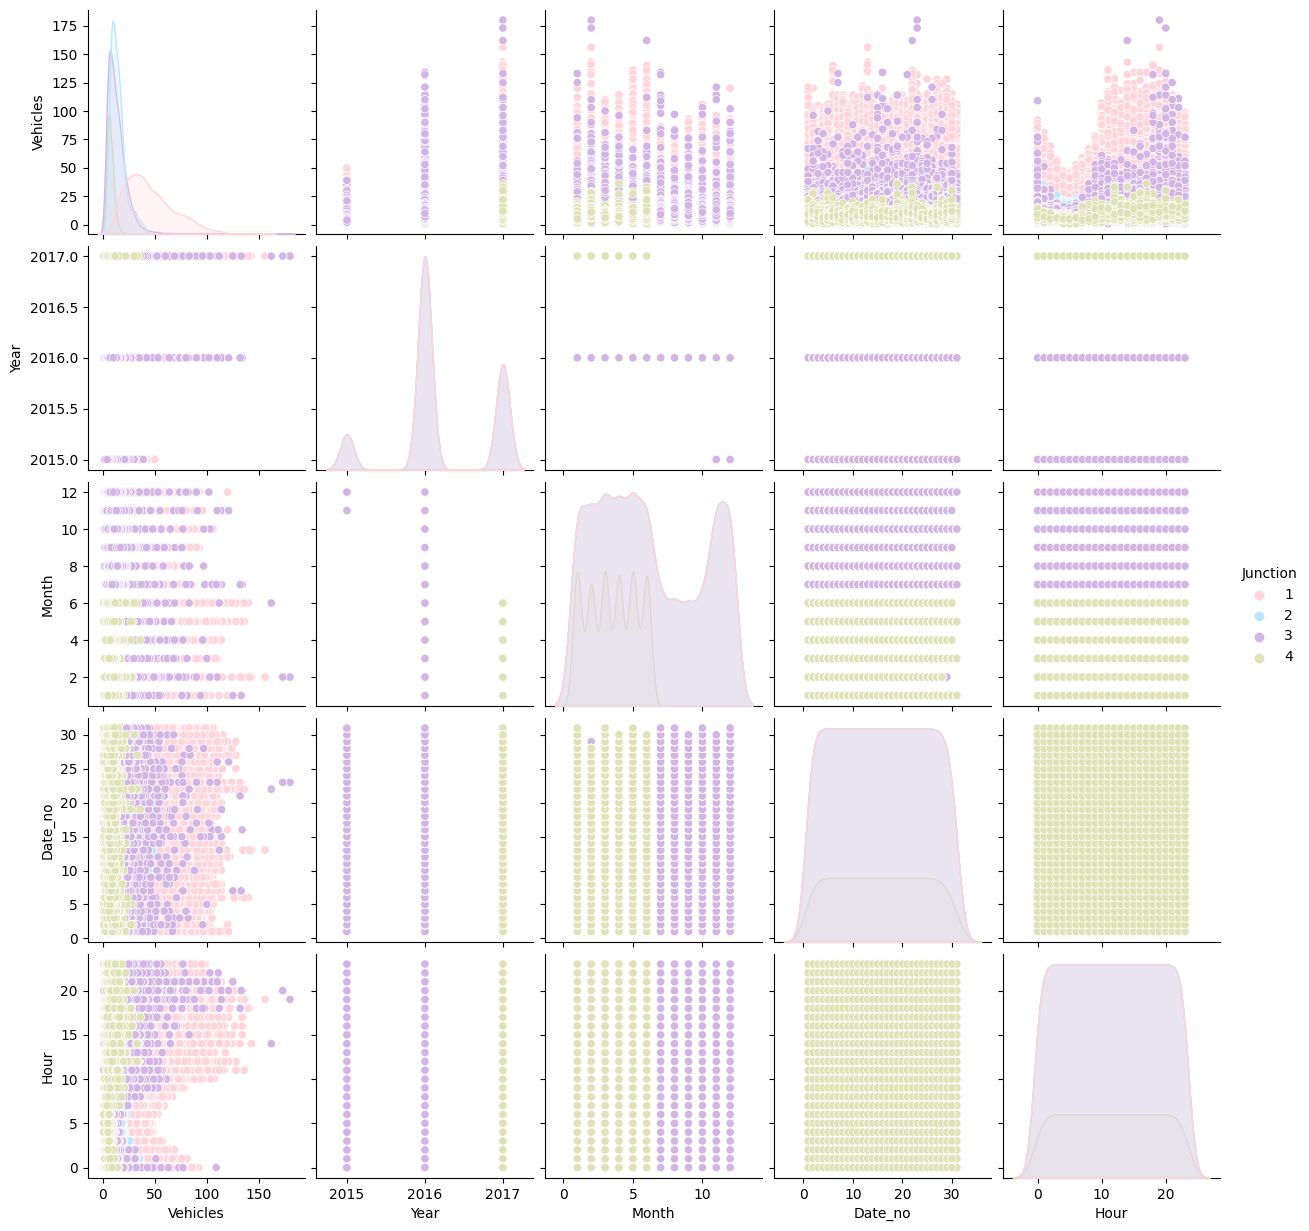

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)


In [ ]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

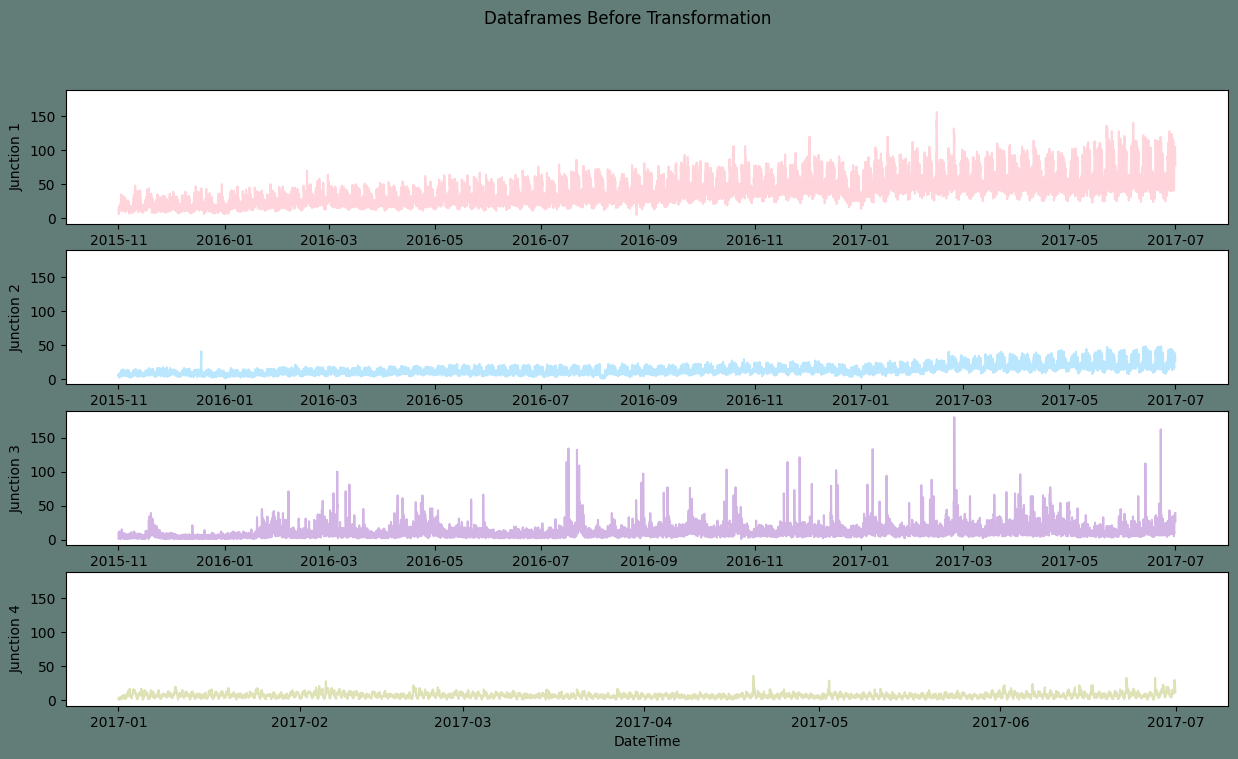

In [ ]:
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")


In [ ]:
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

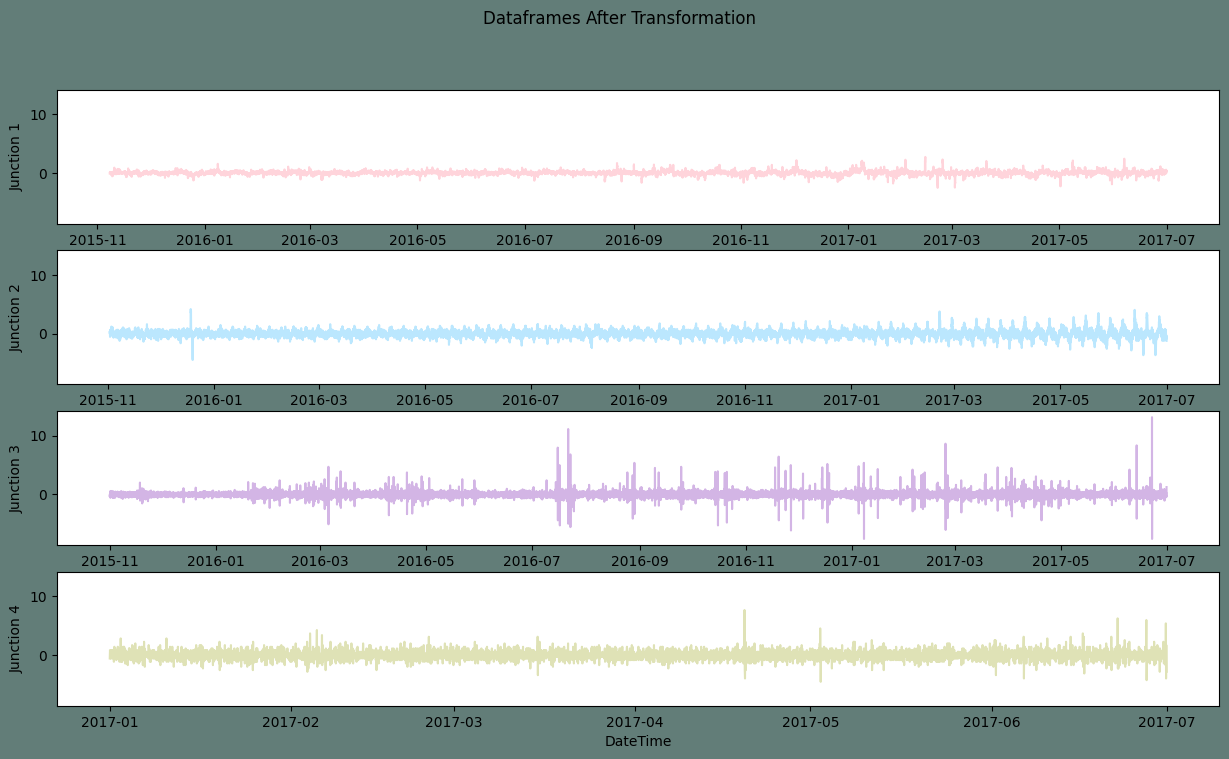

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")


In [ ]:
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)
X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)



In [ ]:
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    initial_learning_rate = 0.01
    lr_schedule = callbacks.LearningRateScheduler(lambda epoch: initial_learning_rate * 0.9 ** epoch)
    optimizer = SGD(learning_rate=initial_learning_rate, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.fit(X_Train, y_Train, epochs=50, batch_size=150, callbacks=[early_stopping, lr_schedule])
    pred_GRU = model.predict(X_Test)
    return pred_GRU
#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
import tensorflow as tf
epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate, decay=decay_rate)

In [ ]:
import tensorflow as tf

# Define a learning rate schedule (e.g., learning rate decay)
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

Epoch 1/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0780

87/87 [==============================] - 9s 15ms/step - loss: 0.0772 - lr: 0.0100
Epoch 2/50
83/87 [===========================>..] - ETA: 0s - loss: 0.0667

87/87 [==============================] - 1s 13ms/step - loss: 0.0667 - lr: 0.0090
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.0650

87/87 [==============================] - 1s 13ms/step - loss: 0.0650 - lr: 0.0081
Epoch 4/50
86/87 [============================>.] - ETA: 0s - loss: 0.0629

87/87 [==============================] - 1s 13ms/step - loss: 0.0631 - lr: 0.0073
Epoch 5/50
87/87 [==============================] - ETA: 0s - loss: 0.0623

87/87 [==============================] - 1s 16ms/step - loss: 0.0623 - lr: 0.0066
Epoch 6/50
85/87 [============================>.] - ETA: 0s - loss: 0.0620

87/87 [==============================] - 1s 16ms/step - loss: 0.0620 - lr: 0.0059
Epoch 7/50
86/87 [============================>.] - ETA: 0s - loss: 0.0610

87/87 [==============================] - 1s 13ms/step - loss: 0.0609 - lr: 0.0053
Epoch 8/50
87/87 [==============================] - ETA: 0s - loss: 0.0604

87/87 [==============================] - 1s 13ms/step - loss: 0.0604 - lr: 0.0048
Epoch 9/50
85/87 [============================>.] - ETA: 0s - loss: 0.0602

87/87 [==============================] - 1s 13ms/step - loss: 0.0601 - lr: 0.0043
Epoch 10/50
86/87 [============================>.] - ETA: 0s - loss: 0.0588

87/87 [==============================] - 1s 13ms/step - loss: 0.0588 - lr: 0.0039
Epoch 11/50
86/87 [============================>.] - ETA: 0s - loss: 0.0595

87/87 [==============================] - 1s 12ms/step - loss: 0.0594 - lr: 0.0035
Epoch 12/50
87/87 [==============================] - ETA: 0s - loss: 0.0589

87/87 [==============================] - 1s 12ms/step - loss: 0.0589 - lr: 0.0031
Epoch 13/50
86/87 [============================>.] - ETA: 0s - loss: 0.0585

87/87 [==============================] - 1s 12ms/step - loss: 0.0584 - lr: 0.0028
Epoch 14/50
85/87 [============================>.] - ETA: 0s - loss: 0.0577

87/87 [==============================] - 1s 13ms/step - loss: 0.0581 - lr: 0.0025
Epoch 15/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0581

87/87 [==============================] - 1s 13ms/step - loss: 0.0581 - lr: 0.0023
Epoch 16/50
87/87 [==============================] - ETA: 0s - loss: 0.0577

87/87 [==============================] - 1s 16ms/step - loss: 0.0577 - lr: 0.0021
Epoch 17/50
86/87 [============================>.] - ETA: 0s - loss: 0.0575

87/87 [==============================] - 1s 14ms/step - loss: 0.0574 - lr: 0.0019
Epoch 18/50
87/87 [==============================] - ETA: 0s - loss: 0.0574

87/87 [==============================] - 1s 12ms/step - loss: 0.0574 - lr: 0.0017
Epoch 19/50
83/87 [===========================>..] - ETA: 0s - loss: 0.0570

87/87 [==============================] - 1s 12ms/step - loss: 0.0571 - lr: 0.0015
Epoch 20/50
86/87 [============================>.] - ETA: 0s - loss: 0.0575

87/87 [==============================] - 1s 12ms/step - loss: 0.0574 - lr: 0.0014
Epoch 21/50
86/87 [============================>.] - ETA: 0s - loss: 0.0569

87/87 [==============================] - 1s 12ms/step - loss: 0.0569 - lr: 0.0012
Epoch 22/50
83/87 [===========================>..] - ETA: 0s - loss: 0.0569

87/87 [==============================] - 1s 13ms/step - loss: 0.0570 - lr: 0.0011
Epoch 23/50
86/87 [============================>.] - ETA: 0s - loss: 0.0570

87/87 [==============================] - 1s 13ms/step - loss: 0.0570 - lr: 9.8477e-04
Epoch 24/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0564

87/87 [==============================] - 1s 13ms/step - loss: 0.0568 - lr: 8.8629e-04
Epoch 25/50
86/87 [============================>.] - ETA: 0s - loss: 0.0570

87/87 [==============================] - 1s 13ms/step - loss: 0.0570 - lr: 7.9766e-04
Epoch 26/50
85/87 [============================>.] - ETA: 0s - loss: 0.0566

87/87 [==============================] - 1s 14ms/step - loss: 0.0566 - lr: 7.1790e-04
Epoch 27/50
87/87 [==============================] - ETA: 0s - loss: 0.0563

87/87 [==============================] - 1s 16ms/step - loss: 0.0563 - lr: 6.4611e-04
Epoch 28/50
87/87 [==============================] - ETA: 0s - loss: 0.0569

87/87 [==============================] - 1s 13ms/step - loss: 0.0569 - lr: 5.8150e-04
Epoch 29/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0567

87/87 [==============================] - 1s 13ms/step - loss: 0.0566 - lr: 5.2335e-04
Epoch 30/50
87/87 [==============================] - ETA: 0s - loss: 0.0568

87/87 [==============================] - 1s 13ms/step - loss: 0.0568 - lr: 4.7101e-04
Epoch 31/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0573

87/87 [==============================] - 1s 12ms/step - loss: 0.0570 - lr: 4.2391e-04
Epoch 32/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0567

87/87 [==============================] - 1s 13ms/step - loss: 0.0563 - lr: 3.8152e-04
Epoch 33/50
87/87 [==============================] - ETA: 0s - loss: 0.0565

87/87 [==============================] - 1s 13ms/step - loss: 0.0565 - lr: 3.4337e-04
Epoch 34/50
87/87 [==============================] - ETA: 0s - loss: 0.0561

87/87 [==============================] - 1s 13ms/step - loss: 0.0561 - lr: 3.0903e-04
Epoch 35/50
87/87 [==============================] - ETA: 0s - loss: 0.0561

87/87 [==============================] - 1s 13ms/step - loss: 0.0561 - lr: 2.7813e-04
Epoch 36/50
83/87 [===========================>..] - ETA: 0s - loss: 0.0563

87/87 [==============================] - 1s 13ms/step - loss: 0.0562 - lr: 2.5032e-04
Epoch 37/50
86/87 [============================>.] - ETA: 0s - loss: 0.0566

87/87 [==============================] - 1s 16ms/step - loss: 0.0566 - lr: 2.2528e-04
Epoch 38/50
85/87 [============================>.] - ETA: 0s - loss: 0.0568

87/87 [==============================] - 1s 16ms/step - loss: 0.0569 - lr: 2.0276e-04
Epoch 39/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0568

87/87 [==============================] - 1s 13ms/step - loss: 0.0567 - lr: 1.8248e-04
Epoch 40/50
85/87 [============================>.] - ETA: 0s - loss: 0.0567

87/87 [==============================] - 1s 13ms/step - loss: 0.0566 - lr: 1.6423e-04
Epoch 41/50
83/87 [===========================>..] - ETA: 0s - loss: 0.0563

87/87 [==============================] - 1s 13ms/step - loss: 0.0561 - lr: 1.4781e-04
Epoch 42/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0562

87/87 [==============================] - 1s 13ms/step - loss: 0.0563 - lr: 1.3303e-04
Epoch 43/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0561

87/87 [==============================] - 1s 13ms/step - loss: 0.0559 - lr: 1.1973e-04
Epoch 44/50
85/87 [============================>.] - ETA: 0s - loss: 0.0563

87/87 [==============================] - 1s 13ms/step - loss: 0.0562 - lr: 1.0775e-04
Epoch 45/50
86/87 [============================>.] - ETA: 0s - loss: 0.0562

87/87 [==============================] - 1s 13ms/step - loss: 0.0561 - lr: 9.6977e-05
Epoch 46/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0563

87/87 [==============================] - 1s 13ms/step - loss: 0.0564 - lr: 8.7280e-05
Epoch 47/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0566

87/87 [==============================] - 1s 16ms/step - loss: 0.0562 - lr: 7.8552e-05
Epoch 48/50
85/87 [============================>.] - ETA: 0s - loss: 0.0562

87/87 [==============================] - 1s 17ms/step - loss: 0.0560 - lr: 7.0697e-05
Epoch 49/50
86/87 [============================>.] - ETA: 0s - loss: 0.0561

87/87 [==============================] - 1s 13ms/step - loss: 0.0561 - lr: 6.3627e-05
Epoch 50/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0558

45/45 [==============================] - 2s 6ms/step
The root mean squared error is 0.2698631194280897.


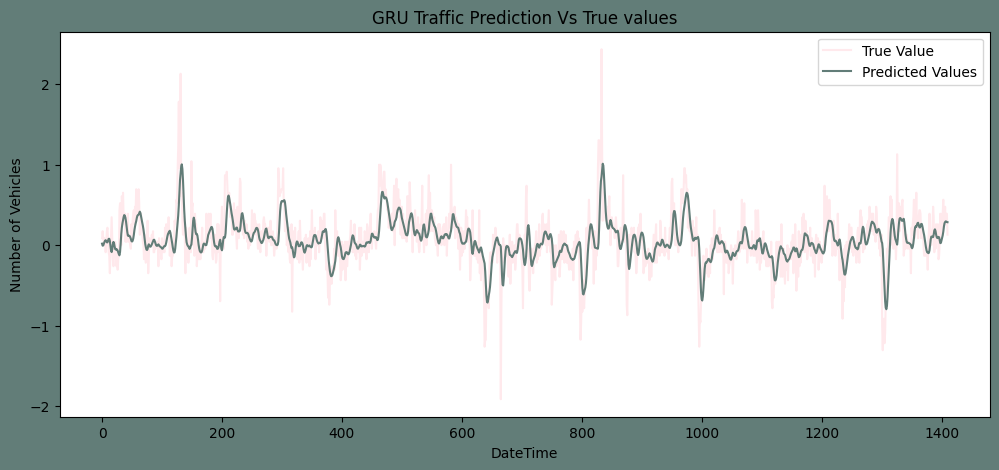

In [ ]:
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

Epoch 1/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6952

26/26 [==============================] - 8s 17ms/step - loss: 0.6904 - lr: 0.0100
Epoch 2/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6873

26/26 [==============================] - 0s 12ms/step - loss: 0.6859 - lr: 0.0090
Epoch 3/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6839

26/26 [==============================] - 0s 13ms/step - loss: 0.6848 - lr: 0.0081
Epoch 4/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6855

26/26 [==============================] - 0s 12ms/step - loss: 0.6824 - lr: 0.0073
Epoch 5/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6814

26/26 [==============================] - 0s 12ms/step - loss: 0.6802 - lr: 0.0066
Epoch 6/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6867

26/26 [==============================] - 0s 13ms/step - loss: 0.6811 - lr: 0.0059
Epoch 7/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6543

26/26 [==============================] - 0s 13ms/step - loss: 0.6819 - lr: 0.0053
Epoch 8/50
26/26 [==============================] - ETA: 0s - loss: 0.6862

26/26 [==============================] - 0s 12ms/step - loss: 0.6862 - lr: 0.0048
Epoch 9/50
26/26 [==============================] - ETA: 0s - loss: 0.6790

26/26 [==============================] - 0s 12ms/step - loss: 0.6790 - lr: 0.0043
Epoch 10/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6748

26/26 [==============================] - 0s 12ms/step - loss: 0.6773 - lr: 0.0039
Epoch 11/50
26/26 [==============================] - ETA: 0s - loss: 0.6760

26/26 [==============================] - 0s 12ms/step - loss: 0.6760 - lr: 0.0035
Epoch 12/50
26/26 [==============================] - ETA: 0s - loss: 0.6778

26/26 [==============================] - 0s 12ms/step - loss: 0.6778 - lr: 0.0031
Epoch 13/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6677

26/26 [==============================] - 0s 12ms/step - loss: 0.6764 - lr: 0.0028
Epoch 14/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6805

26/26 [==============================] - 0s 13ms/step - loss: 0.6792 - lr: 0.0025
Epoch 15/50
22/26 [========================>.....] - ETA: 0s - loss: 0.6603

26/26 [==============================] - 0s 13ms/step - loss: 0.6785 - lr: 0.0023
Epoch 16/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6713

26/26 [==============================] - 0s 13ms/step - loss: 0.6785 - lr: 0.0021
Epoch 17/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6798

26/26 [==============================] - 0s 13ms/step - loss: 0.6755 - lr: 0.0019
Epoch 18/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6735

26/26 [==============================] - 0s 13ms/step - loss: 0.6758 - lr: 0.0017
Epoch 19/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6806

26/26 [==============================] - 0s 12ms/step - loss: 0.6746 - lr: 0.0015
Epoch 20/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6805

26/26 [==============================] - 0s 12ms/step - loss: 0.6767 - lr: 0.0014
Epoch 21/50
26/26 [==============================] - ETA: 0s - loss: 0.6753

26/26 [==============================] - 0s 12ms/step - loss: 0.6753 - lr: 0.0012
Epoch 22/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6812

26/26 [==============================] - 0s 13ms/step - loss: 0.6744 - lr: 0.0011
Epoch 23/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6643

26/26 [==============================] - 0s 12ms/step - loss: 0.6747 - lr: 9.8477e-04
Epoch 24/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6727

26/26 [==============================] - 0s 13ms/step - loss: 0.6763 - lr: 8.8629e-04
Epoch 25/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6823

26/26 [==============================] - 0s 13ms/step - loss: 0.6755 - lr: 7.9766e-04
Epoch 26/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6726

26/26 [==============================] - 0s 13ms/step - loss: 0.6737 - lr: 7.1790e-04
Epoch 27/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6740

26/26 [==============================] - 0s 17ms/step - loss: 0.6754 - lr: 6.4611e-04
Epoch 28/50
26/26 [==============================] - ETA: 0s - loss: 0.6730

26/26 [==============================] - 0s 17ms/step - loss: 0.6730 - lr: 5.8150e-04
Epoch 29/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6743

26/26 [==============================] - 0s 16ms/step - loss: 0.6730 - lr: 5.2335e-04
Epoch 30/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6771

26/26 [==============================] - 0s 17ms/step - loss: 0.6732 - lr: 4.7101e-04
Epoch 31/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6725

26/26 [==============================] - 0s 16ms/step - loss: 0.6740 - lr: 4.2391e-04
Epoch 32/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6760

26/26 [==============================] - 0s 13ms/step - loss: 0.6732 - lr: 3.8152e-04
Epoch 33/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6707

26/26 [==============================] - 0s 12ms/step - loss: 0.6706 - lr: 3.4337e-04
Epoch 34/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6704

26/26 [==============================] - 0s 12ms/step - loss: 0.6737 - lr: 3.0903e-04
Epoch 35/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6775

26/26 [==============================] - 0s 13ms/step - loss: 0.6733 - lr: 2.7813e-04
Epoch 36/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6674

26/26 [==============================] - 0s 13ms/step - loss: 0.6721 - lr: 2.5032e-04
Epoch 37/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6781

26/26 [==============================] - 0s 13ms/step - loss: 0.6734 - lr: 2.2528e-04
Epoch 38/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6760

26/26 [==============================] - 0s 12ms/step - loss: 0.6726 - lr: 2.0276e-04
Epoch 39/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6811

26/26 [==============================] - 0s 13ms/step - loss: 0.6726 - lr: 1.8248e-04
Epoch 40/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6770

26/26 [==============================] - 0s 13ms/step - loss: 0.6734 - lr: 1.6423e-04
Epoch 41/50
22/26 [========================>.....] - ETA: 0s - loss: 0.6707

26/26 [==============================] - 0s 13ms/step - loss: 0.6719 - lr: 1.4781e-04
Epoch 42/50
26/26 [==============================] - ETA: 0s - loss: 0.6732

26/26 [==============================] - 0s 14ms/step - loss: 0.6732 - lr: 1.3303e-04
Epoch 43/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6682

26/26 [==============================] - 0s 13ms/step - loss: 0.6721 - lr: 1.1973e-04
Epoch 44/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6719

26/26 [==============================] - 0s 13ms/step - loss: 0.6727 - lr: 1.0775e-04
Epoch 45/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6783

26/26 [==============================] - 0s 13ms/step - loss: 0.6732 - lr: 9.6977e-05
Epoch 46/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6710

26/26 [==============================] - 0s 13ms/step - loss: 0.6736 - lr: 8.7280e-05
Epoch 47/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6693

26/26 [==============================] - 0s 13ms/step - loss: 0.6725 - lr: 7.8552e-05
Epoch 48/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6747

26/26 [==============================] - 0s 13ms/step - loss: 0.6724 - lr: 7.0697e-05
Epoch 49/50
22/26 [========================>.....] - ETA: 0s - loss: 0.6729

26/26 [==============================] - 0s 13ms/step - loss: 0.6733 - lr: 6.3627e-05
Epoch 50/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6755

13/13 [==============================] - 2s 8ms/step
The root mean squared error is 1.1030918710707318.


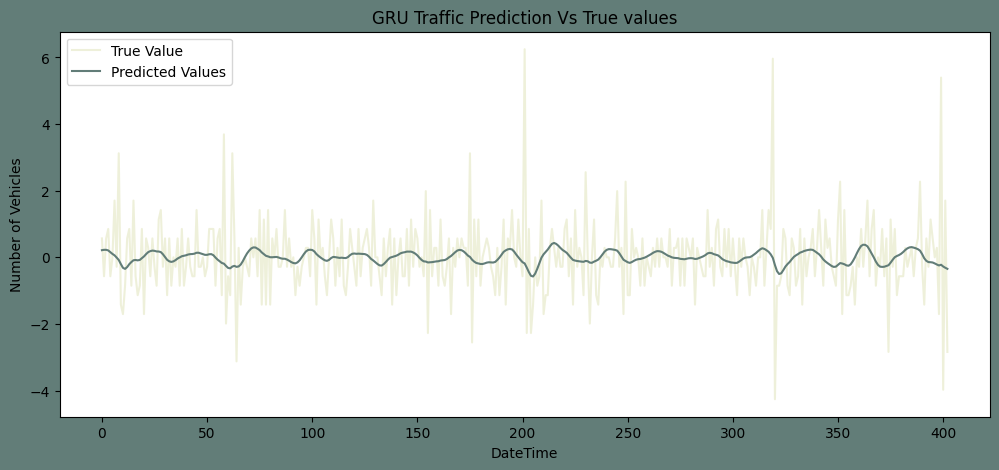

In [ ]:
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.2316

88/88 [==============================] - 9s 14ms/step - loss: 0.2316 - lr: 0.0100
Epoch 2/50
84/88 [===========================>..] - ETA: 0s - loss: 0.2031

88/88 [==============================] - 1s 12ms/step - loss: 0.2050 - lr: 0.0090
Epoch 3/50
86/88 [============================>.] - ETA: 0s - loss: 0.1986

88/88 [==============================] - 1s 15ms/step - loss: 0.1984 - lr: 0.0081
Epoch 4/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1980

88/88 [==============================] - 1s 15ms/step - loss: 0.1984 - lr: 0.0073
Epoch 5/50
84/88 [===========================>..] - ETA: 0s - loss: 0.1949

88/88 [==============================] - 1s 12ms/step - loss: 0.1952 - lr: 0.0066
Epoch 6/50
88/88 [==============================] - ETA: 0s - loss: 0.1937

88/88 [==============================] - 1s 12ms/step - loss: 0.1937 - lr: 0.0059
Epoch 7/50
86/88 [============================>.] - ETA: 0s - loss: 0.1920

88/88 [==============================] - 1s 12ms/step - loss: 0.1923 - lr: 0.0053
Epoch 8/50
86/88 [============================>.] - ETA: 0s - loss: 0.1932

88/88 [==============================] - 1s 12ms/step - loss: 0.1926 - lr: 0.0048
Epoch 9/50
87/88 [============================>.] - ETA: 0s - loss: 0.1920

88/88 [==============================] - 1s 12ms/step - loss: 0.1922 - lr: 0.0043
Epoch 10/50
88/88 [==============================] - ETA: 0s - loss: 0.1906

88/88 [==============================] - 1s 12ms/step - loss: 0.1906 - lr: 0.0039
Epoch 11/50
88/88 [==============================] - ETA: 0s - loss: 0.1904

88/88 [==============================] - 1s 12ms/step - loss: 0.1904 - lr: 0.0035
Epoch 12/50
88/88 [==============================] - ETA: 0s - loss: 0.1907

88/88 [==============================] - 1s 12ms/step - loss: 0.1907 - lr: 0.0031
Epoch 13/50
88/88 [==============================] - ETA: 0s - loss: 0.1909

88/88 [==============================] - 1s 12ms/step - loss: 0.1909 - lr: 0.0028
Epoch 14/50
86/88 [============================>.] - ETA: 0s - loss: 0.1883

88/88 [==============================] - 1s 15ms/step - loss: 0.1892 - lr: 0.0025
Epoch 15/50
84/88 [===========================>..] - ETA: 0s - loss: 0.1883

88/88 [==============================] - 1s 15ms/step - loss: 0.1889 - lr: 0.0023
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.1889

88/88 [==============================] - 1s 12ms/step - loss: 0.1889 - lr: 0.0021
Epoch 17/50
88/88 [==============================] - ETA: 0s - loss: 0.1890

88/88 [==============================] - 1s 12ms/step - loss: 0.1890 - lr: 0.0019
Epoch 18/50
86/88 [============================>.] - ETA: 0s - loss: 0.1892

88/88 [==============================] - 1s 12ms/step - loss: 0.1888 - lr: 0.0017
Epoch 19/50
86/88 [============================>.] - ETA: 0s - loss: 0.1881

88/88 [==============================] - 1s 12ms/step - loss: 0.1885 - lr: 0.0015
Epoch 20/50
84/88 [===========================>..] - ETA: 0s - loss: 0.1893

88/88 [==============================] - 1s 12ms/step - loss: 0.1883 - lr: 0.0014
Epoch 21/50
84/88 [===========================>..] - ETA: 0s - loss: 0.1877

88/88 [==============================] - 1s 12ms/step - loss: 0.1877 - lr: 0.0012
Epoch 22/50
86/88 [============================>.] - ETA: 0s - loss: 0.1890

88/88 [==============================] - 1s 13ms/step - loss: 0.1884 - lr: 0.0011
Epoch 23/50
87/88 [============================>.] - ETA: 0s - loss: 0.1879

88/88 [==============================] - 1s 12ms/step - loss: 0.1879 - lr: 9.8477e-04
Epoch 24/50
87/88 [============================>.] - ETA: 0s - loss: 0.1886

88/88 [==============================] - 1s 12ms/step - loss: 0.1885 - lr: 8.8629e-04
Epoch 25/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1882

88/88 [==============================] - 1s 15ms/step - loss: 0.1886 - lr: 7.9766e-04
Epoch 26/50
84/88 [===========================>..] - ETA: 0s - loss: 0.1873

88/88 [==============================] - 1s 14ms/step - loss: 0.1875 - lr: 7.1790e-04
Epoch 27/50
88/88 [==============================] - ETA: 0s - loss: 0.1881

88/88 [==============================] - 1s 12ms/step - loss: 0.1881 - lr: 6.4611e-04
Epoch 28/50
87/88 [============================>.] - ETA: 0s - loss: 0.1864

88/88 [==============================] - 1s 12ms/step - loss: 0.1862 - lr: 5.8150e-04
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.1873

88/88 [==============================] - 1s 12ms/step - loss: 0.1873 - lr: 5.2335e-04
Epoch 30/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1875

88/88 [==============================] - 1s 12ms/step - loss: 0.1883 - lr: 4.7101e-04
Epoch 31/50
84/88 [===========================>..] - ETA: 0s - loss: 0.1881

88/88 [==============================] - 1s 12ms/step - loss: 0.1869 - lr: 4.2391e-04
Epoch 32/50
87/88 [============================>.] - ETA: 0s - loss: 0.1873

88/88 [==============================] - 1s 12ms/step - loss: 0.1872 - lr: 3.8152e-04
Epoch 33/50
84/88 [===========================>..] - ETA: 0s - loss: 0.1869

88/88 [==============================] - 1s 12ms/step - loss: 0.1887 - lr: 3.4337e-04
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.1875

88/88 [==============================] - 1s 12ms/step - loss: 0.1875 - lr: 3.0903e-04
Epoch 35/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1873

88/88 [==============================] - 1s 13ms/step - loss: 0.1875 - lr: 2.7813e-04
Epoch 36/50
88/88 [==============================] - ETA: 0s - loss: 0.1861

88/88 [==============================] - 1s 15ms/step - loss: 0.1861 - lr: 2.5032e-04
Epoch 37/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1870

88/88 [==============================] - 1s 14ms/step - loss: 0.1866 - lr: 2.2528e-04
Epoch 38/50
86/88 [============================>.] - ETA: 0s - loss: 0.1877

88/88 [==============================] - 1s 12ms/step - loss: 0.1874 - lr: 2.0276e-04
Epoch 39/50
87/88 [============================>.] - ETA: 0s - loss: 0.1879

88/88 [==============================] - 1s 12ms/step - loss: 0.1877 - lr: 1.8248e-04
Epoch 40/50
84/88 [===========================>..] - ETA: 0s - loss: 0.1865

88/88 [==============================] - 1s 13ms/step - loss: 0.1858 - lr: 1.6423e-04
Epoch 41/50
87/88 [============================>.] - ETA: 0s - loss: 0.1870

88/88 [==============================] - 1s 12ms/step - loss: 0.1869 - lr: 1.4781e-04
Epoch 42/50
87/88 [============================>.] - ETA: 0s - loss: 0.1875

88/88 [==============================] - 1s 12ms/step - loss: 0.1874 - lr: 1.3303e-04
Epoch 43/50
86/88 [============================>.] - ETA: 0s - loss: 0.1863

88/88 [==============================] - 1s 12ms/step - loss: 0.1867 - lr: 1.1973e-04
Epoch 44/50
86/88 [============================>.] - ETA: 0s - loss: 0.1863

88/88 [==============================] - 1s 12ms/step - loss: 0.1864 - lr: 1.0775e-04
Epoch 45/50
86/88 [============================>.] - ETA: 0s - loss: 0.1878

88/88 [==============================] - 1s 12ms/step - loss: 0.1874 - lr: 9.6977e-05
Epoch 46/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1873

88/88 [==============================] - 1s 13ms/step - loss: 0.1870 - lr: 8.7280e-05
Epoch 47/50
88/88 [==============================] - ETA: 0s - loss: 0.1877

88/88 [==============================] - 1s 15ms/step - loss: 0.1877 - lr: 7.8552e-05
Epoch 48/50
84/88 [===========================>..] - ETA: 0s - loss: 0.1868

88/88 [==============================] - 1s 14ms/step - loss: 0.1861 - lr: 7.0697e-05
Epoch 49/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1880

88/88 [==============================] - 1s 12ms/step - loss: 0.1876 - lr: 6.3627e-05
Epoch 50/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1880

45/45 [==============================] - 2s 6ms/step
The root mean squared error is 0.5754676533333426.


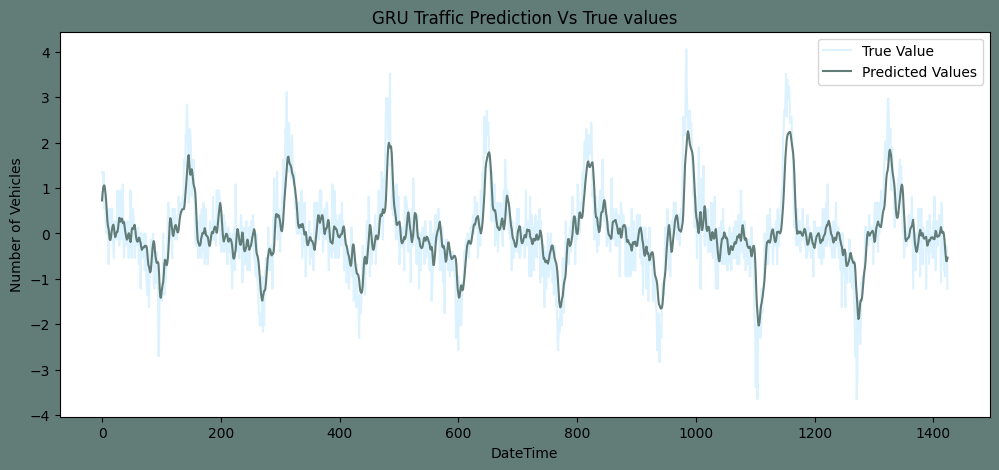

In [ ]:
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.3003

88/88 [==============================] - 9s 16ms/step - loss: 0.3003 - lr: 0.0100
Epoch 2/50
86/88 [============================>.] - ETA: 0s - loss: 0.2960

88/88 [==============================] - 1s 12ms/step - loss: 0.2945 - lr: 0.0090
Epoch 3/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2835

88/88 [==============================] - 1s 12ms/step - loss: 0.2909 - lr: 0.0081
Epoch 4/50
87/88 [============================>.] - ETA: 0s - loss: 0.2909

88/88 [==============================] - 1s 12ms/step - loss: 0.2916 - lr: 0.0073
Epoch 5/50
87/88 [============================>.] - ETA: 0s - loss: 0.2895

88/88 [==============================] - 1s 12ms/step - loss: 0.2888 - lr: 0.0066
Epoch 6/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2876

88/88 [==============================] - 1s 12ms/step - loss: 0.2877 - lr: 0.0059
Epoch 7/50
88/88 [==============================] - ETA: 0s - loss: 0.2872

88/88 [==============================] - 1s 12ms/step - loss: 0.2872 - lr: 0.0053
Epoch 8/50
84/88 [===========================>..] - ETA: 0s - loss: 0.2912

88/88 [==============================] - 1s 12ms/step - loss: 0.2878 - lr: 0.0048
Epoch 9/50
88/88 [==============================] - ETA: 0s - loss: 0.2854

88/88 [==============================] - 1s 12ms/step - loss: 0.2854 - lr: 0.0043
Epoch 10/50
86/88 [============================>.] - ETA: 0s - loss: 0.2887

88/88 [==============================] - 1s 13ms/step - loss: 0.2871 - lr: 0.0039
Epoch 11/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2868

88/88 [==============================] - 1s 15ms/step - loss: 0.2861 - lr: 0.0035
Epoch 12/50
86/88 [============================>.] - ETA: 0s - loss: 0.2845

88/88 [==============================] - 1s 14ms/step - loss: 0.2855 - lr: 0.0031
Epoch 13/50
86/88 [============================>.] - ETA: 0s - loss: 0.2880

88/88 [==============================] - 1s 12ms/step - loss: 0.2860 - lr: 0.0028
Epoch 14/50
87/88 [============================>.] - ETA: 0s - loss: 0.2821

88/88 [==============================] - 1s 12ms/step - loss: 0.2850 - lr: 0.0025
Epoch 15/50
87/88 [============================>.] - ETA: 0s - loss: 0.2843

88/88 [==============================] - 1s 12ms/step - loss: 0.2848 - lr: 0.0023
Epoch 16/50
87/88 [============================>.] - ETA: 0s - loss: 0.2853

88/88 [==============================] - 1s 12ms/step - loss: 0.2849 - lr: 0.0021
Epoch 17/50
87/88 [============================>.] - ETA: 0s - loss: 0.2855

88/88 [==============================] - 1s 12ms/step - loss: 0.2851 - lr: 0.0019
Epoch 18/50
87/88 [============================>.] - ETA: 0s - loss: 0.2833

88/88 [==============================] - 1s 12ms/step - loss: 0.2841 - lr: 0.0017
Epoch 19/50
88/88 [==============================] - ETA: 0s - loss: 0.2834

88/88 [==============================] - 1s 12ms/step - loss: 0.2834 - lr: 0.0015
Epoch 20/50
86/88 [============================>.] - ETA: 0s - loss: 0.2762

88/88 [==============================] - 1s 12ms/step - loss: 0.2838 - lr: 0.0014
Epoch 21/50
87/88 [============================>.] - ETA: 0s - loss: 0.2846

88/88 [==============================] - 1s 13ms/step - loss: 0.2839 - lr: 0.0012
Epoch 22/50
88/88 [==============================] - ETA: 0s - loss: 0.2836

88/88 [==============================] - 1s 15ms/step - loss: 0.2836 - lr: 0.0011
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.2830

88/88 [==============================] - 1s 14ms/step - loss: 0.2830 - lr: 9.8477e-04
Epoch 24/50
87/88 [============================>.] - ETA: 0s - loss: 0.2822

88/88 [==============================] - 1s 12ms/step - loss: 0.2831 - lr: 8.8629e-04
Epoch 25/50
86/88 [============================>.] - ETA: 0s - loss: 0.2835

88/88 [==============================] - 1s 12ms/step - loss: 0.2820 - lr: 7.9766e-04
Epoch 26/50
87/88 [============================>.] - ETA: 0s - loss: 0.2836

88/88 [==============================] - 1s 12ms/step - loss: 0.2829 - lr: 7.1790e-04
Epoch 27/50
87/88 [============================>.] - ETA: 0s - loss: 0.2834

88/88 [==============================] - 1s 12ms/step - loss: 0.2831 - lr: 6.4611e-04
Epoch 28/50
86/88 [============================>.] - ETA: 0s - loss: 0.2837

88/88 [==============================] - 1s 13ms/step - loss: 0.2836 - lr: 5.8150e-04
Epoch 29/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2821

88/88 [==============================] - 1s 13ms/step - loss: 0.2832 - lr: 5.2335e-04
Epoch 30/50
87/88 [============================>.] - ETA: 0s - loss: 0.2834

88/88 [==============================] - 1s 12ms/step - loss: 0.2827 - lr: 4.7101e-04
Epoch 31/50
86/88 [============================>.] - ETA: 0s - loss: 0.2807

88/88 [==============================] - 1s 13ms/step - loss: 0.2824 - lr: 4.2391e-04
Epoch 32/50
88/88 [==============================] - ETA: 0s - loss: 0.2823

88/88 [==============================] - 1s 14ms/step - loss: 0.2823 - lr: 3.8152e-04
Epoch 33/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2776

88/88 [==============================] - 1s 16ms/step - loss: 0.2829 - lr: 3.4337e-04
Epoch 34/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2811

88/88 [==============================] - 1s 13ms/step - loss: 0.2825 - lr: 3.0903e-04
Epoch 35/50
86/88 [============================>.] - ETA: 0s - loss: 0.2848

88/88 [==============================] - 1s 13ms/step - loss: 0.2838 - lr: 2.7813e-04
Epoch 36/50
86/88 [============================>.] - ETA: 0s - loss: 0.2841

88/88 [==============================] - 1s 13ms/step - loss: 0.2832 - lr: 2.5032e-04
Epoch 37/50
86/88 [============================>.] - ETA: 0s - loss: 0.2741

88/88 [==============================] - 1s 12ms/step - loss: 0.2824 - lr: 2.2528e-04
Epoch 38/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2705

88/88 [==============================] - 1s 12ms/step - loss: 0.2823 - lr: 2.0276e-04
Epoch 39/50
86/88 [============================>.] - ETA: 0s - loss: 0.2840

88/88 [==============================] - 1s 12ms/step - loss: 0.2825 - lr: 1.8248e-04
Epoch 40/50
87/88 [============================>.] - ETA: 0s - loss: 0.2849

88/88 [==============================] - 1s 13ms/step - loss: 0.2840 - lr: 1.6423e-04
Epoch 41/50
86/88 [============================>.] - ETA: 0s - loss: 0.2827

88/88 [==============================] - 1s 13ms/step - loss: 0.2824 - lr: 1.4781e-04
Epoch 42/50
88/88 [==============================] - ETA: 0s - loss: 0.2828

88/88 [==============================] - 1s 13ms/step - loss: 0.2828 - lr: 1.3303e-04
Epoch 43/50
87/88 [============================>.] - ETA: 0s - loss: 0.2832

88/88 [==============================] - 1s 15ms/step - loss: 0.2824 - lr: 1.1973e-04
Epoch 44/50
86/88 [============================>.] - ETA: 0s - loss: 0.2813

88/88 [==============================] - 1s 15ms/step - loss: 0.2814 - lr: 1.0775e-04
Epoch 45/50
86/88 [============================>.] - ETA: 0s - loss: 0.2827

88/88 [==============================] - 1s 12ms/step - loss: 0.2823 - lr: 9.6977e-05
Epoch 46/50
87/88 [============================>.] - ETA: 0s - loss: 0.2836

88/88 [==============================] - 1s 12ms/step - loss: 0.2830 - lr: 8.7280e-05
Epoch 47/50
87/88 [============================>.] - ETA: 0s - loss: 0.2829

88/88 [==============================] - 1s 13ms/step - loss: 0.2824 - lr: 7.8552e-05
Epoch 48/50
88/88 [==============================] - ETA: 0s - loss: 0.2826

88/88 [==============================] - 1s 12ms/step - loss: 0.2826 - lr: 7.0697e-05
Epoch 49/50
84/88 [===========================>..] - ETA: 0s - loss: 0.2838

88/88 [==============================] - 1s 12ms/step - loss: 0.2820 - lr: 6.3627e-05
Epoch 50/50
86/88 [============================>.] - ETA: 0s - loss: 0.2843

45/45 [==============================] - 2s 6ms/step
The root mean squared error is 0.6235629447941445.


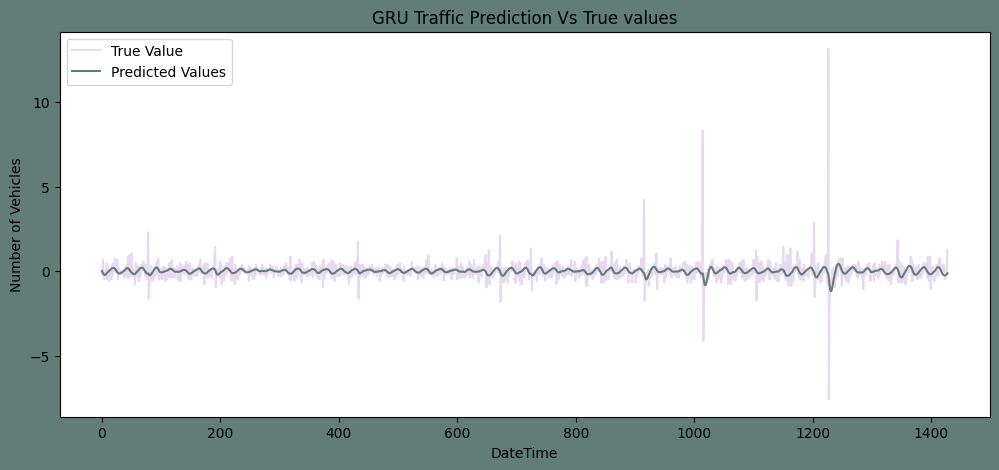

In [ ]:
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3)
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)